<a href="https://colab.research.google.com/github/nathanaelsee/diffplasticity-RNN/blob/master/diffplastRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiable Plasticity RNN
## An Extension of Uber's Differentiable Plasticity:
https://github.com/uber-research/differentiable-plasticity/

Testing the effectiveness of the differentiable plasticity network as an RNN model

## Examples/tutorials used:

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html  
https://jovianlin.io/pytorch-with-gpu-in-google-colab/ (for working with Pytorch and CUDA on Google Colab)  

# Install PyTorch

In [0]:
!pip3 install torch
    
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable

print("PyTorch version:", torch.__version__)
print("CUDA version:\t", torch.version.cuda)
!nvidia-smi

PyTorch version: 1.0.0
CUDA version:	 9.0.176
Sat Dec 15 01:44:39 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                              

# Download Dataset

Dataset of names and their lingustic backgrounds taken from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [0]:
import os

if os.path.exists('data/names') == False:
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip

# Process Dataset into Training & Test sets
Using a random 90-10 split on each category to preserve the dataset ratios

In [0]:
from __future__ import unicode_literals, division
from io import open
import unicodedata
import string
import glob
import random

all_letters = string.ascii_lowercase + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    s = s.lower()
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

print('Ślusàrski ->', unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_lines = []
line_table = []
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# One-hot vector per character
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Split data into training and test sets
ratio = 0.9

training_set = []
test_set = []

category_id = 0
for filename in glob.glob('data/names/*.txt'):
    
    category = os.path.splitext(os.path.basename(filename))[0]
    # Hack: to reduce dataset bias
    #if category == "Russian" or category == "English": continue
    all_categories.append(category)
    
    lines = readLines(filename)
    random.shuffle(lines)
    
    # Hack: to reduce dataset bias
    #if category == "Russian" or category == "English": lines = lines[:3000]
    
    category_lines[category] = lines
    table = [(line, category_id, lineToTensor(line)) for line in lines]
    
    # Split category to training/test sets
    tmp = int(len(table) * ratio)
    training_set += table[:tmp]
    test_set += table[tmp:]
    
    all_lines += lines
    line_table += table
    
    category_id += 1

n_data = len(all_lines)
n_training = len(training_set)
n_test = len(test_set)

#random.shuffle(line_table)
random.shuffle(training_set)
random.shuffle(test_set)

#training_set = line_table[:n_training]
#test_set = line_table[n_training:]
training_dict = {line:(cat, tensor) for line, cat, tensor in training_set}
test_dict = {line:(cat, tensor) for line, cat, tensor in test_set}

for category in all_categories :
    print('%s:   \t%d' % (category, len(category_lines[category])))
print("Input dataset size:", n_data)
print("Training set size:", len(training_set))
print("Test set size:", len(test_set))

Ślusàrski -> slusarski
Spanish:   	298
English:   	3668
Irish:   	232
Portuguese:   	74
Arabic:   	2000
Vietnamese:   	73
Chinese:   	268
French:   	277
Greek:   	203
Dutch:   	297
German:   	724
Scottish:   	100
Polish:   	139
Czech:   	519
Russian:   	9408
Korean:   	94
Italian:   	709
Japanese:   	991
Input dataset size: 20074
Training set size: 18060
Test set size: 2014


# Build the model

Credits to Uber: https://github.com/uber-research/differentiable-plasticity/  
Modifications made to original sample code.

In [0]:
class DiffPlastRNN(nn.Module):
    def __init__(self, input_size, num_classes):
        
        super(DiffPlastRNN, self).__init__()
        self.input_size = input_size
        
        # Initialize trainable parameters
        self.w     = nn.Parameter(.01 * torch.randn(input_size, input_size), requires_grad=True) # The matrix of fixed (baseline) weights
        self.alpha = nn.Parameter(.01 * torch.randn(input_size, input_size), requires_grad=True) # The matrix of plasticity coefficients
        self.eta   = nn.Parameter(.01 * torch.ones(1),                       requires_grad=True) # The "learning rate" of plasticity - scalar-valued
        
        # 2-layer MLP on top of hidden state for classification
        self.l1 = nn.Linear(input_size, input_size)
        self.nonlin = nn.Tanh()
        self.l2 = nn.Linear(input_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)           # Softmax layer on classification

    # Run the network for one timestep
    def forward(self, input, x_in, hebb):
        
        # hidden state - using tanh as non-linearity, as per paper
        x_out = torch.tanh( x_in.mm(self.w + torch.mul(self.alpha, hebb)) + input )
        
        # Hebbian trace
        hebb = (1 - self.eta) * hebb + self.eta * torch.bmm(x_in.unsqueeze(2), x_out.unsqueeze(1))[0] 
        # bmm here is used to implement an outer product between yin and yout, with the help of unsqueeze (i.e. added empty dimensions)
        
        # log softmax output for classification
        output = self.softmax(self.l2(self.nonlin(self.l1(x_out))))
        
        return x_out, hebb, output

    # RuntimeError if not using CUDA
    def checkCuda(self):
        self.w.get_device()
        self.alpha.get_device()
        self.eta.get_device()
        
    # Return an initialized, all-zero hidden state
    def initialZeroState(self):
        return torch.zeros(1, self.input_size)

    # Return an initialized, all-zero Hebbian trace
    def initialZeroHebb(self):
        return torch.zeros(self.input_size, self.input_size)

# Initialize Network with Hyperparameters

In [0]:
# Hyperparameters
n_letters = len(all_letters)
n_categories = len(all_categories)
learning_rate = 0.0001

# Initialize net & training settings
net = DiffPlastRNN(n_letters, n_categories)
loss_func = nn.NLLLoss() # negative log likelihood loss
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # Adam optimizer - more nuanced than basic grad desc

# Load from model info if previously saved
if os.path.exists('model.pt') == True:
    net = torch.load('model.pt')
    print("Pre-trained model data loaded")

# Enable CUDA if available
if torch.cuda.is_available():
    net.cuda()
    net.checkCuda()
    print("Using CUDA!")
else:
    net.cpu()
    print("Using CPU!")

Using CUDA!


# Define training & predicting methods

In [0]:
def getExample(index, dataset):
    line, category_id, line_tensor = dataset[index]
    category = all_categories[category_id]
    category_tensor = torch.tensor([category_id], dtype=torch.long)
    return category, line, category_tensor.cuda(), line_tensor.cuda()

def iterate(category_tensor, line_tensor, train=True):
    x_in = net.initialZeroState().cuda()
    hebb = net.initialZeroHebb().cuda()

    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        x_in, hebb, output = net(line_tensor[i], x_in, hebb)

    loss = loss_func(output, category_tensor)
    if train:
        loss.backward()
        optimizer.step()

    return output, loss.item()

def evaluate(line_tensor):
    x_in = net.initialZeroState().cuda()
    hebb = net.initialZeroHebb().cuda()

    for i in range(line_tensor.size()[0]):
        x_in, hebb, output = net(line_tensor[i], x_in, hebb)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        line = unicodeToAscii(input_line)
        
        if line in training_dict:
            print(line, "found in training dataset, category", all_categories[training_dict[line][0]])
        else:
            print(line, "not found in training dataset")
            if line in test_dict:
                print(line, "found in test dataset, category", all_categories[test_dict[line][0]])
            else:
                print(line, "not found in dataset")
        
        output = evaluate(lineToTensor(line).cuda())

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f%%) %s' % (np.exp(value) * 100, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

# Train Model on Training Set
Running 20 epochs, each epoch is a forward pass and backward pass over the shuffled training set.    
Test set is also iterated over to collect test loss for plotting

In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
training_losses = []
test_losses = []
start = time.time()
def train(training_losses, test_losses):
    
    n_iters = n_training
    print_every = n_iters // 1
    plot_every = n_iters // 10

    print_loss = 0
    plot_loss = 0
    n_corr = 0

    print(" Done   | Time Elapsed  | Avg Loss | Accuracy | Input / Guess (Actual)")
    print("---------------------------------------------------------------------------------")
    for iter in range(0, n_iters):
        category, line, category_tensor, line_tensor = getExample(iter, training_set)
        output, loss = iterate(category_tensor, line_tensor)
        guess, guess_i = categoryFromOutput(output)
        if guess == category: n_corr += 1
        print_loss += loss
        plot_loss += loss

        # Print iter number, loss, name and guess
        if (iter + 1) % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print(' %d%%\t|   %s\t|  %.4f  |  %.2f%%  | %s / %s %s' % ((iter + 1) / n_iters * 50, timeSince(start), print_loss / print_every, n_corr / print_every * 100, line, guess, correct))
            print_loss = 0
            n_corr = 0

        # Add current loss avg to list of losses
        if (iter + 1) % plot_every == 0:
            training_losses.append(plot_loss / plot_every)
            plot_loss = 0
            test(test_losses)
            
    print_loss = 0
    plot_loss = 0
    n_corr = 0

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = getExample(n_iters - iter, training_set)
        output, loss = iterate(category_tensor, line_tensor)
        guess, guess_i = categoryFromOutput(output)
        if guess == category: n_corr += 1
        print_loss += loss
        plot_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print(' %d%%\t|   %s\t|  %.4f  |  %.2f%%  | %s / %s %s' % (iter / n_iters * 50 + 50, timeSince(start), print_loss / print_every, n_corr / print_every * 100, line, guess, correct))
            print_loss = 0
            n_corr = 0

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            training_losses.append(plot_loss / plot_every)
            plot_loss = 0
            test(test_losses)

    
def test(test_losses, cm = False):
    
    test_start = time.time()

    total_test_loss = 0
    correct = 0

    for iter in range(0, n_test):
        category, line, category_tensor, line_tensor = getExample(iter, test_set)
        output, loss = iterate(category_tensor, line_tensor, train=False)
        total_test_loss += loss

        guess, guess_i = categoryFromOutput(output)
        if guess == category: correct += 1
        category_i = all_categories.index(category)
        if cm: confusion[category_i][guess_i] += 1

    test_loss = total_test_loss / n_test
    accuracy = correct / n_test
    test_losses.append(test_loss)
    
    if cm: print("Test time taken:", timeSince(test_start), ", loss: %.4f, accuracy: %.4f%%" % (test_loss, accuracy * 100))

In [9]:
epochs = 20
for i in range(epochs):
    random.shuffle(training_set)
    print("Epoch", i+1)
    train(training_losses, test_losses)

Epoch 1
 Done   | Time Elapsed  | Avg Loss | Accuracy | Input / Guess (Actual)
---------------------------------------------------------------------------------
 50%	|   8m 33s	|  1.6608  |  50.57%  | ronflard / English ✓
 100%	|   17m 29s	|  1.3308  |  60.84%  | brain / Russian ✗ (English)
Epoch 2
 Done   | Time Elapsed  | Avg Loss | Accuracy | Input / Guess (Actual)
---------------------------------------------------------------------------------
 50%	|   26m 28s	|  1.1906  |  65.61%  | hevrolin / Russian ✓
 100%	|   35m 26s	|  1.1025  |  68.32%  | gorskikh / Russian ✓
Epoch 3
 Done   | Time Elapsed  | Avg Loss | Accuracy | Input / Guess (Actual)
---------------------------------------------------------------------------------
 50%	|   44m 27s	|  1.0492  |  69.69%  | bekoryukov / Russian ✓
 100%	|   53m 27s	|  1.0120  |  70.54%  | ponurovsky / Russian ✓
Epoch 4
 Done   | Time Elapsed  | Avg Loss | Accuracy | Input / Guess (Actual)
-----------------------------------------------------

# Plot loss
Red line is training loss    
Blue line is test loss

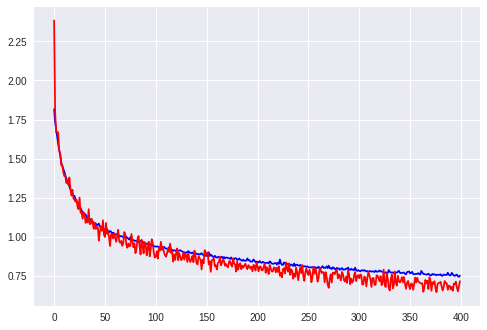

In [10]:
import matplotlib.pyplot as plt

graph = plt.figure()
axes = plt.gca()
#axes.set_ylim([0, 2])
y = range(len(test_losses))
plt.plot(y, test_losses, 'b')
plt.plot(y, training_losses, 'r') 
plt.show()

# Confusion Matrix

Test time taken: 0m 17s , loss: 0.7516, accuracy: 78.2026%


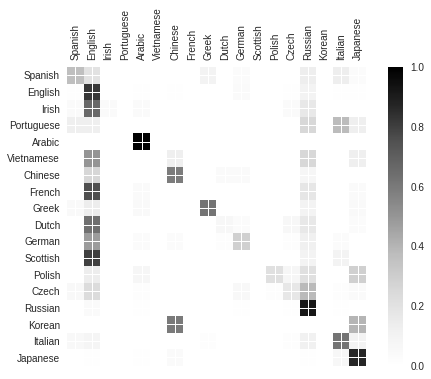

In [18]:
import matplotlib.ticker as ticker

confusion = torch.zeros(n_categories, n_categories)
tmp = []
test(tmp, cm=True)

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Make Predictions

In [12]:
predict('Saruwatari') # Japanese surname
predict('Aitmukhambetov') # Kazakhstani surname - not a provided category
predict('Bergen')


> Saruwatari
saruwatari not found in training dataset
saruwatari not found in dataset
(56.68%) Japanese
(23.27%) Russian
(13.26%) Italian

> Aitmukhambetov
aitmukhambetov not found in training dataset
aitmukhambetov not found in dataset
(99.97%) Russian
(0.02%) Arabic
(0.00%) English

> Bergen
bergen not found in training dataset
bergen not found in dataset
(38.98%) English
(24.10%) Russian
(23.07%) German


# Save model

In [0]:
from google.colab import files

torch.save(net, 'model.pt')

files.download('model.pt')